# pNML Resnet18 CIFAR10 

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
import time
import json
import pandas as pd
import copy
import seaborn as sns
import sys
%run ./result_summary.ipynb
%run ./plot_functions.ipynb
sys.path.insert(0, '../src/')

output_path =  ../output/figures
plt = single_column_plt_params(plt)


In [2]:
from analyze_utilities import *
from dataset_utilities import create_cifar10_dataloaders
plt = single_column_plt_params(plt)

Files already downloaded and verified
Files already downloaded and verified


# PNML Vs. ERM Performence
PNML is as training is as following:
1. Train base model with all trainset
2. Freeze first layers (only enable updates of layer 5,6 in resnet20)
3. For each test sample:
    1. For each label:
        1. Add the test sample with the label to trainset
        2. Train for 10 epochs the model
        3. Keep probability of the test sample label which it was trained with
    2. Take all save probabilities and normalize them.
    3. Report the new probability assignment

In [3]:
# Print acc and mean loss
tic = time.time()
result_df, statistics_df = load_results_to_df(files_nml_2_layers)
print('result_df: loaded in {0:.2f} [s]'.format(time.time() - tic))
print(statistics_df.transpose())
print(result_df.shape[0])

result_df: loaded in 1.95 [s]
          acc  mean loss  std loss  mean entropy
nml    0.9184   0.167210  0.313679      0.197706
erm    0.9183   0.194359  0.821636      0.024840
genie  0.9875   0.027294  0.230810      0.024752
10000


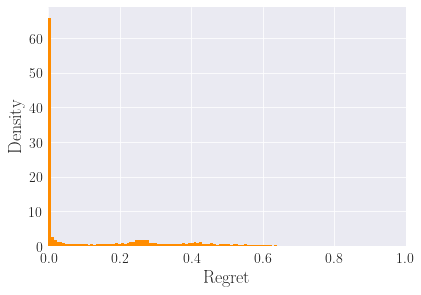

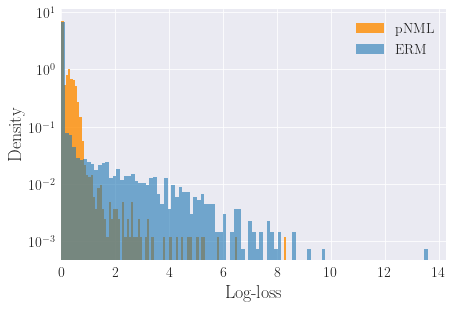

In [4]:
# Regret histogram
bins = 100
plt.hist(result_df['log10_norm_factor'], density=True,
         label='pNML', bins=bins, color='darkorange')
plt.xlim([-0.0001, 1])
plt.title('Regret Histogram') if is_plot_title else None
plt.xlabel('Regret')
plt.ylabel('Density')
# plt.savefig(os.path.join(output_path, 'figure_regret_hist.jpg'), dpi=200,
#             bbox_inches=plt.tight_layout()) if is_save_fig else None
plt.show()

# logloss histogram
bins = 100
plt.hist(result_df['nml_loss'], bins=bins, alpha=0.8,
         label='pNML', density=True, color='darkorange')
plt.hist(result_df['erm_loss'], bins=bins,
         alpha=0.6, label='ERM', density=True)
plt.title('Logloss Histogram') if is_plot_title else None
plt.xlabel('Log-loss')
plt.ylabel('Density')
plt.yscale('log')
plt.xlim(left=0)
plt.legend()
plt.savefig(os.path.join(output_path, 'figure_logloss_hist.pdf'), dpi=300,
            bbox_inches=plt.tight_layout()) if is_save_fig else None
plt.show()

/Users/kobibi/anaconda3/envs/pt36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


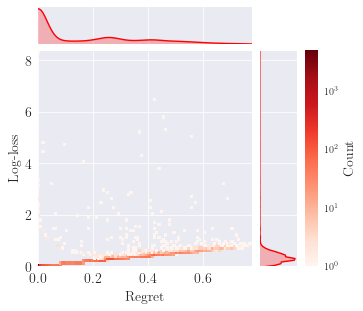

In [5]:
x_data = list(result_df['log10_norm_factor'])
y_data = list(result_df['nml_loss'])
g = sns.JointGrid(x=x_data,  y=y_data)
g.plot_marginals(sns.kdeplot, shade=True, color='red')
g.plot_joint(plt.hist2d, bins=[100, 100], norm=mpl.colors.SymLogNorm(0.1),
             cmin=1, cmap=plt.cm.Reds)
g.ax_joint.grid(True)
label_size = plt.rcParams['axes.labelsize']
g.ax_joint.set_ylabel('Log-loss', fontsize=label_size-4)
g.ax_joint.set_xlabel('Regret', fontsize=label_size-4)

# make new ax object for the cbar
plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)
cbar_ax = g.fig.add_axes([.82, 0.2, .03, .5])  # x, y, width, height
plt.colorbar(cax=cbar_ax).set_label(label='Count', fontsize=label_size-4)
cbar_ax.tick_params(labelsize=10)
# plt.savefig(os.path.join(output_path, 'figure_loss_vs_regret_jointplot.pdf'), dpi=300,
#             bbox_inches='tight',  bbox_extra_artists=(cbar_ax,),) if is_save_fig else None
plt.show()

6.4


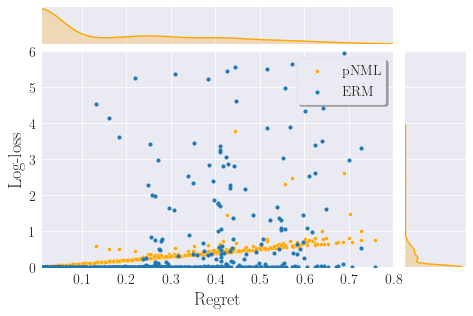

In [34]:
subsample = 10


x_data = list(result_df['log10_norm_factor'][::subsample])
y_data = list(result_df['nml_loss'][::subsample])
g = sns.JointGrid(x=x_data,  y=y_data,  xlim=(0.01, 0.8), ylim=(0, 6))

g.plot_marginals(sns.kdeplot, shade=True, color='orange')
g.plot_joint(plt.scatter, c='orange',  edgecolor="white", label='pNML', s=14)

# Add scatter of erm
g.x = result_df['log10_norm_factor'][::subsample]
g.y = result_df['erm_loss'][::subsample]
g.plot_joint(plt.scatter, c='C0', label='ERM', s=14)

g.ax_joint.grid(True)
g.ax_joint.set_ylabel('Log-loss', fontsize=label_size)
g.ax_joint.set_xlabel('Regret', fontsize=label_size)

plt.legend()
plt.legend(frameon=True, shadow=True)

height = 4
g.fig.set_figwidth(6.4)
g.fig.set_figheight(4.0)
print(fig.get_figwidth())

plt.savefig(os.path.join(output_path, 'figure_loss_vs_regret_jointplot_scatter.pdf'), dpi=300,
            bbox_inches='tight') if is_save_fig else None
plt.show()

In [20]:
fig = plt.figure()
size = fig.get_size_inches()
size

array([6.4, 4.4])

<Figure size 460.8x316.8 with 0 Axes>

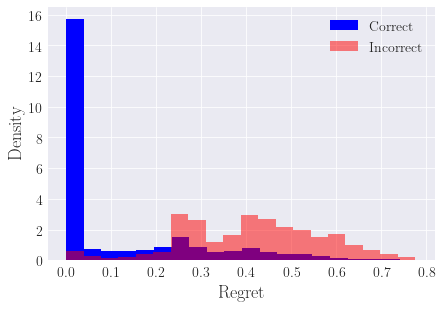


Correct = 9184, Incorrect = 816 
Mean [correct, incorrect]=[0.1156757391744595, 0.41274406045452866]


In [7]:
# Plot histogram of correct vs incorrect
correct_norm_factor = result_df['log10_norm_factor'][result_df['nml_is_correct'] == True]
incorrect_norm_factor = result_df['log10_norm_factor'][result_df['nml_is_correct'] == False]

bins = 20

plt.hist(correct_norm_factor, alpha=1, bins=bins,
         density=True, color='blue', label='Correct')
plt.hist(incorrect_norm_factor, alpha=0.5, bins=bins,
         density=True, color='red', label='Incorrect')
plt.title(
    'Regret Histogram with Correct and Incorrect Separation') if is_plot_title else None
plt.xlabel('Regret')
plt.ylabel('Density')
plt.legend()
plt.savefig(os.path.join(output_path, 'figure_correct_incorrect_hist.pdf'), dpi=300,
            bbox_inches=plt.tight_layout()) if is_save_fig else None
plt.show()

print()
print('Correct = %d, Incorrect = %d ' %
      (correct_norm_factor.shape[0], incorrect_norm_factor.shape[0]))
print('Mean [correct, incorrect]={}'.format(
    [correct_norm_factor.mean(), incorrect_norm_factor.mean()]))

# Compose Regret based Estimator

In [8]:
#  Construct best loss based on normalization factor
threshold_list = np.linspace(np.finfo(float).eps, 1, 99)
acc_list = []
acc_erm_list = []
cdf_list = []
nml_thresh_loss_list = []
erm_thresh_loss_list = []
for threshold in threshold_list:
    df = result_df[result_df['log10_norm_factor'] < threshold]

    # loss
    nml_thresh_loss_list.append(df['nml_loss'].mean())
    erm_thresh_loss_list.append(df['erm_loss'].mean())

    # Acc
    acc_single = np.sum(df['nml_is_correct'] == True) / \
        (df.shape[0] + np.finfo(float).eps)
    acc_list.append(acc_single)
    acc_erm_single = np.sum(df['erm_is_correct'] == True) / \
        (df.shape[0] + np.finfo(float).eps)
    acc_erm_list.append(acc_erm_single)

    cdf_single = df.shape[0] / result_df.shape[0]
    cdf_list.append(cdf_single)

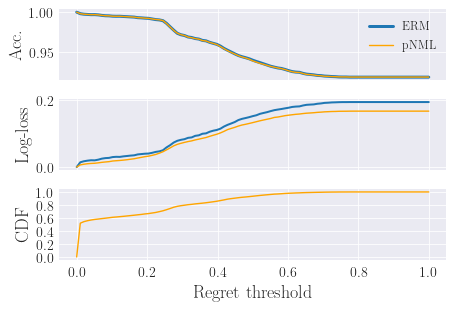

,CDF,Regret thresh,acc
0,0.0008,2.220446e-16,1.000000
1,0.5198,1.020408e-02,0.998076
2,0.5434,2.040816e-02,0.997424
3,0.5577,3.061224e-02,0.997131
4,0.5688,4.081633e-02,0.996835
5,0.5773,5.102041e-02,0.996882
6,0.5835,6.122449e-02,0.996572
7,0.5903,7.142857e-02,0.995934
8,0.5968,8.163265e-02,0.995476
9,0.6036,9.183673e-02,0.995361


In [9]:
gs = gridspec.GridSpec(3, 1)
# Acc
acc_color = 'royalblue'
ax1 = plt.subplot(gs[0])
ax1.plot(threshold_list, acc_erm_list, '-',
         label='ERM', color='C0',  linewidth=3)
ax1.plot(threshold_list, acc_list, label='pNML', color='orange')
ax1.set_ylabel('Acc.')
plt.legend(fontsize=12)

labels = [item.get_text() for item in ax1.get_xticklabels()]
empty_string_labels = [''] * len(labels)
ax1.set_xticklabels(empty_string_labels)

# Loss
loss_color = 'green'
ax2 = plt.subplot(gs[1])
ax2.plot(threshold_list, erm_thresh_loss_list, '-',
         label='ERM', color='C0',  linewidth=2)
ax2.plot(threshold_list, nml_thresh_loss_list, label='pNML', color='orange')
ax2.set_ylabel('Log-loss')
labels = [item.get_text() for item in ax2.get_xticklabels()]
empty_string_labels = [''] * len(labels)
ax2.set_xticklabels(empty_string_labels)

# CDF
ax3 = plt.subplot(gs[2])
ax3.plot(threshold_list, cdf_list, color='orange')
ax3.set_yticks(np.linspace(0, 1, 6))
ax3.set_xlabel('Regret threshold')
ax3.set_ylabel('CDF')

# Save and show
plt.savefig(os.path.join(output_path, 'figure_regret_based_classifier.pdf'),
            dpi=300, bbox_inches=plt.tight_layout()) if is_save_fig else None
plt.show()

pd.DataFrame(
    {'CDF': cdf_list, 'Regret thresh': threshold_list, 'acc': acc_list})

# Visualize False classified
Visaulaize the image of the false classified by the ERM and NML

In [10]:
result_df.head()

,nml_0,nml_1,nml_2,nml_3,nml_4,nml_5,nml_6,nml_7,nml_8,nml_9,...,genie_4,genie_5,genie_6,genie_7,genie_8,genie_9,genie_true_label,genie_loss,genie_entropy,genie_is_correct
0,1.629999e-13,5.649397e-09,2.312400e-09,9.999995e-01,1.374499e-12,4.867780e-07,7.174366e-10,6.239996e-14,5.089637e-11,8.499996e-15,...,0.000000e+00,1.518500e-12,9.000000e-15,0.000000e+00,1.000000e-16,0.000000e+00,3,-9.643275e-17,1.896885e-11,True
1,2.803199e-09,1.077142e-05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.999978e-16,0.000000e+00,9.999892e-01,3.374964e-13,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,8,-9.643275e-17,2.523635e-10,True
10,5.552505e-01,3.662312e-08,2.646956e-05,3.006416e-01,1.687820e-02,1.271869e-01,1.843239e-07,1.220476e-05,4.522384e-09,3.927093e-06,...,4.611952e-08,8.485354e-07,8.763199e-12,1.907152e-10,4.653500e-12,2.051346e-10,0,1.915566e-06,2.671863e-05,True
11,3.343000e-13,6.079150e-11,0.000000e+00,1.000000e-16,0.000000e+00,3.320000e-14,0.000000e+00,5.850000e-13,1.770000e-14,1.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,9,-9.643275e-17,3.614825e-14,True
12,1.006575e-08,4.056829e-08,1.386666e-04,9.381318e-03,3.284797e-01,3.300510e-01,1.688912e-01,1.630580e-01,5.034552e-12,1.190244e-11,...,5.048739e-02,9.494844e-01,4.784360e-06,2.051660e-05,1.100000e-15,3.400000e-15,5,2.251216e-02,8.698527e-02,True


In [11]:
# Check when erm and nml are not agree
disagree = np.logical_not(
    np.logical_and(np.array(result_df['nml_is_correct']), np.array(np.array(result_df['erm_is_correct']))))
disagree_indxes = np.array(result_df.index.values)[
    disagree == True].astype(np.int).tolist()
print(disagree_indxes)

[12, 35, 52, 58, 59, 61, 112, 118, 128, 129, 147, 158, 160, 165, 169, 171, 178, 188, 192, 223, 224, 226, 232, 281, 284, 306, 312, 340, 342, 357, 368, 370, 378, 384, 411, 412, 418, 426, 433, 456, 459, 474, 477, 478, 483, 531, 549, 562, 598, 618, 631, 665, 671, 675, 680, 683, 710, 725, 727, 731, 734, 739, 770, 793, 796, 799, 810, 811, 836, 862, 866, 882, 888, 893, 900, 910, 923, 924, 925, 933, 943, 953, 956, 972, 993, 994, 1019, 1040, 1042, 1049, 1050, 1072, 1088, 1095, 1100, 1118, 1129, 1131, 1150, 1163, 1172, 1181, 2005, 2023, 2034, 2036, 2046, 2061, 2066, 2078, 2091, 2128, 2159, 2161, 2165, 2172, 2186, 2187, 2205, 2226, 2232, 2242, 2251, 2262, 2270, 2271, 2283, 2293, 2299, 2309, 2331, 2350, 2355, 2361, 2362, 2372, 2394, 2405, 2419, 2442, 2444, 2459, 2466, 2468, 2494, 2495, 7000, 7002, 7005, 7016, 7041, 7059, 7068, 7080, 7082, 7099, 7107, 7112, 7143, 7147, 7150, 7168, 7174, 7177, 7202, 7218, 7235, 7246, 7274, 7311, 7343, 7347, 7367, 7370, 7384, 7398, 7400, 7406, 7408, 7414, 7439, 7446,

Files already downloaded and verified
Files already downloaded and verified


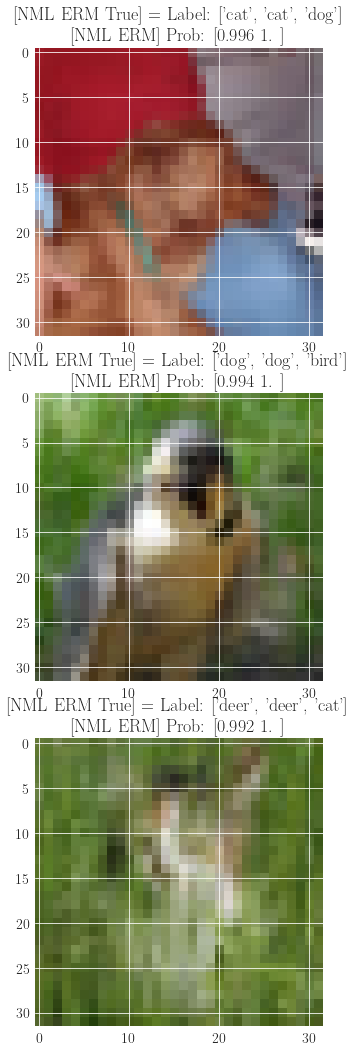

In [12]:
# Given a dict an idx, visualize ERM and NMl with prob of each. along with ground truth

# Inputs
results_dict = load_dict_from_file_list(files_nml_2_layers)
dict_idxes = [158, 384, 456]  # disagree_indxes # [245, 246]

# Initialize dataset and plots
fig = plt.figure(figsize=(20, 6 * len(dict_idxes)))
trainloader, testloader, classes = create_cifar10_dataloaders('../data', 1, 1)

# Loop on dict indxes
for iter_idx, dict_idx in enumerate(dict_idxes):
    prob_nml, true_label, predicted_label, prob_erm = extract_probabilities_list(
        results_dict[str(dict_idx)])
    prob_nml, normalization_factor = execute_normalize_prob(prob_nml)

    # Extract class names
    class_predict_nml = classes[np.argmax(prob_nml)]
    class_predict_erm = classes[np.argmax(prob_erm)]
    class_predict_gt = classes[true_label]
    # Extract image
    data = testloader.dataset.test_data[dict_idx]

    # Plot the image
    ax = fig.add_subplot(len(dict_idxes), 1, iter_idx + 1)
    ax.imshow(data)
    ax.set_title('[NML ERM True] = Label: {} \n [NML ERM] Prob: {}'
                 .format([class_predict_nml, class_predict_erm, class_predict_gt],
                         np.round([prob_nml[np.argmax(prob_nml)], prob_erm[np.argmax(prob_erm)]], 3)))

plt.show()